In [1]:
import ee
from statgis.gee import time_series_analysis, zonal_statistics, landsat_functions, utils
import matplotlib.pyplot as plt

ee.Initialize()

In [2]:
munis_path = "projects/ee-srnarvaez/assets/municipios_colombia_100k"

munis = ee.FeatureCollection(munis_path)
munis.size().getInfo()

1122

In [3]:
dibulla = munis.filter(ee.Filter.eq("MpNombre", "Dibulla")).first()
geom = dibulla.geometry()

dibulla.getInfo()["properties"]

{'Depto': 'La Guajira',
 'MpAltitud': 3,
 'MpArea': 1746.7868335975315,
 'MpCategor': 1,
 'MpCodigo': '44090',
 'MpNombre': 'Dibulla',
 'MpNorma': 'Ordenanza No. 30 de 1995',
 'OBJECTID': 1113,
 'Restriccio': '“No es apropiada su aplicación para la ubicación exacta de puntos ni para el cálculo de áreas y distancias'}

In [4]:
landsat_collection = ee.ImageCollection([])

for code in ["LT05", "LE07", "LC08", "LC09"]:
    landsat_collection = landsat_collection.merge(
        ee.ImageCollection(f"LANDSAT/{code}/C02/T1_L2")
        .filterBounds(geom)
        .filterDate("1985-01-01", "2022-12-31")
        .map(landsat_functions.scaler)
        .map(landsat_functions.cloud_mask)
        .map(landsat_functions.rename_bands)
        .map(lambda img: img.select(["BLUE", "GREEN", "RED", "NIR"]))
        .map(lambda img: img.addBands(img.normalizedDifference(["NIR", "RED"]).rename("NDVI")))
    )

                                                            
landsat_collection.size().getInfo()

1624

In [5]:
chirps_collection = (
    ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").filterDate("1985-01-01", "2022-12-31")
)

In [6]:
annual_prec = time_series_analysis.resample(chirps_collection, ee.Reducer.sum(), "annual")
annual_ndvi = (
    time_series_analysis.resample(landsat_collection, ee.Reducer.median(), "annual")
    .map(utils.calculate_band_number)
    .filter(ee.Filter.gt("bands", 0))
)

In [7]:
ndvi = zonal_statistics.zonal_statistics_collection(annual_ndvi, geom, 1000, "NDVI", ee.Reducer.mean())
prec = zonal_statistics.zonal_statistics_collection(annual_prec, geom, 1000, "precipitation", ee.Reducer.mean())

In [8]:
df = prec.merge(ndvi, on="date", how="left")[["date", "NDVI", "precipitation"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 37
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           38 non-null     datetime64[ns]
 1   NDVI           34 non-null     float64       
 2   precipitation  38 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.2 KB


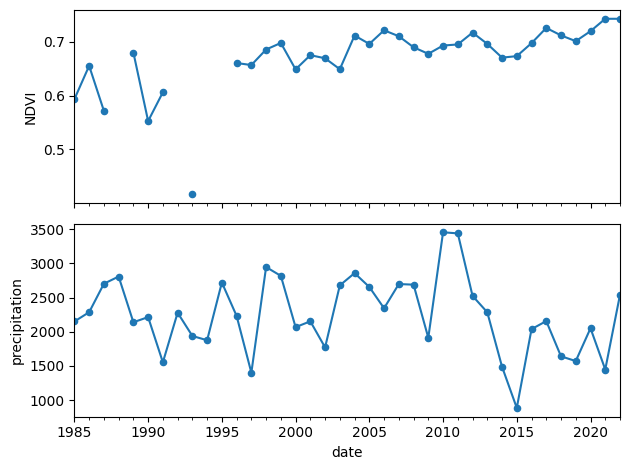

In [9]:
fig, axs = plt.subplots(2, 1, sharex=True, tight_layout=True)
df.plot(x="date", y="NDVI", ax=axs[0], legend=False)
df.plot(x="date", y="NDVI", kind="scatter", ax=axs[0], legend=False)
df.plot(x="date", y="precipitation", ax=axs[1], legend=False)
df.plot(x="date", y="precipitation", kind="scatter", ax=axs[1], legend=False)
plt.show()

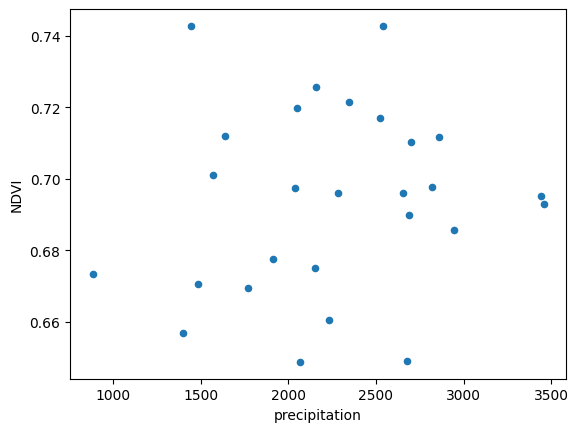

In [10]:
df.query("NDVI > 0.5 & date > '1995-01-01'").plot(x="precipitation", y="NDVI", kind="scatter")
plt.show()